In [6]:
from PIL import Image
import pytesseract
import argparse
import cv2
import os
from skimage.filters import threshold_local
import matplotlib.pyplot as plt
from googletrans import Translator
import imutils
import numpy as np
%matplotlib inline

def showImage(img,title,gray=False):
    #img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    if(gray):
       plt.figure(), plt.title(title),plt.imshow(img,cmap = plt.get_cmap('gray')),plt.xticks([]), plt.yticks([]) 
    else:     
       plt.figure(), plt.title(title),plt.imshow(img),plt.xticks([]), plt.yticks([])



In [7]:

def order_points(pts):
	# initialzie a list of coordinates that will be ordered
	# such that the first entry in the list is the top-left,
	# the second entry is the top-right, the third is the
	# bottom-right, and the fourth is the bottom-left
	rect = np.zeros((4, 2), dtype = "float32")
 
	# the top-left point will have the smallest sum, whereas
	# the bottom-right point will have the largest sum
	s = pts.sum(axis = 1)
	rect[0] = pts[np.argmin(s)]
	rect[2] = pts[np.argmax(s)]
 
	# now, compute the difference between the points, the
	# top-right point will have the smallest difference,
	# whereas the bottom-left will have the largest difference
	diff = np.diff(pts, axis = 1)
	rect[1] = pts[np.argmin(diff)]
	rect[3] = pts[np.argmax(diff)]
 
	# return the ordered coordinates
	return rect
def four_point_transform(image, pts):
	# obtain a consistent order of the points and unpack them
	# individually
	rect = order_points(pts)
	(tl, tr, br, bl) = rect
 
	# compute the width of the new image, which will be the
	# maximum distance between bottom-right and bottom-left
	# x-coordiates or the top-right and top-left x-coordinates
	widthA = np.sqrt(((br[0] - bl[0]) ** 2) + ((br[1] - bl[1]) ** 2))
	widthB = np.sqrt(((tr[0] - tl[0]) ** 2) + ((tr[1] - tl[1]) ** 2))
	maxWidth = max(int(widthA), int(widthB))
 
	# compute the height of the new image, which will be the
	# maximum distance between the top-right and bottom-right
	# y-coordinates or the top-left and bottom-left y-coordinates
	heightA = np.sqrt(((tr[0] - br[0]) ** 2) + ((tr[1] - br[1]) ** 2))
	heightB = np.sqrt(((tl[0] - bl[0]) ** 2) + ((tl[1] - bl[1]) ** 2))
	maxHeight = max(int(heightA), int(heightB))
 
	# now that we have the dimensions of the new image, construct
	# the set of destination points to obtain a "birds eye view",
	# (i.e. top-down view) of the image, again specifying points
	# in the top-left, top-right, bottom-right, and bottom-left
	# order
	dst = np.array([
		[0, 0],
		[maxWidth - 1, 0],
		[maxWidth - 1, maxHeight - 1],
		[0, maxHeight - 1]], dtype = "float32")
 
	# compute the perspective transform matrix and then apply it
	M = cv2.getPerspectiveTransform(rect, dst)
	warped = cv2.warpPerspective(image, M, (maxWidth, maxHeight))
 
	# return the warped image
	return warped



In [18]:
def rotate_image(image):
    def calc_rectangle(array ):
        if len(array)== 4:
            y = array[1,0,1]-array[0,0,1]
            x = array[3,0,0]-array[1,0,0]
            rect_area = x*y
        else:
            rect_area = 0 
            
        return rect_area 
    ratio = image.shape[0] / 500.0
    orig = image.copy()
    image = imutils.resize(image, height = 500)

    # convert the image to grayscale, blur it, and find edges
    # in the image
    gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    gray = cv2.GaussianBlur(gray, (5, 5), 0)
    edged = cv2.Canny(gray, 75, 200)

    # show the original image and the edge detected image
    #showImage(image,"orginal",gray=False)
    #showImage(edged,"edged",gray=True)

    cnts = cv2.findContours(edged.copy(), cv2.RETR_LIST, cv2.CHAIN_APPROX_SIMPLE)
    cnts = cnts[0] if imutils.is_cv2() else cnts[1]
    cnts = sorted(cnts, key = cv2.contourArea, reverse = True)[:5]
    screenCnt = [] 
    # loop over the contours
    for c in cnts:
        # approximate the contour

        peri = cv2.arcLength(c, True)
        approx = cv2.approxPolyDP(c, 0.02 * peri, True)

        # if our approximated contour has four points, then we
        # can assume that we have found our screen
        if (len(approx) == 4):
            screenCnt = approx

        break

    # show the contour (outline) of the piece of paper
    #print("STEP 2: Find contours of paper")
    if (  len(screenCnt)  != 0  and calc_rectangle(screenCnt) > 500      ):
        cv2.drawContours(image, [screenCnt], -1, (0, 255, 0), 2)
        warped = four_point_transform(orig, screenCnt.reshape(4, 2) * ratio)
    
    
    else:    
        warped=image





    # convert the warped image to grayscale, then threshold it
    # to give it that 'black and white' paper effect
    warped = cv2.cvtColor(warped, cv2.COLOR_BGR2GRAY)
    T = threshold_local(warped, 11, offset = 10, method = "gaussian")
    warped = (warped > T).astype("uint8") * 255
    #denoised = cv2.fastNlMeansDenoising(warped , 11, 31, 9)
    #thresh = cv2.adaptiveThreshold(warped, 255, cv2.ADAPTIVE_THRESH_GAUSSIAN_C, cv2.THRESH_BINARY, 11, 2)
    #equ = cv2.equalizeHist(warped )
    #thresh = cv2.adaptiveThreshold(equ,255, cv2.ADAPTIVE_THRESH_GAUSSIAN_C, cv2.THRESH_BINARY, 11, 2)
    # show the original and scanned image

    return cv2.resize(warped,(orig.shape[1], orig.shape[0]), interpolation = cv2.INTER_CUBIC)
image = cv2.imread("test1.jpg",1)
modify=rotate_image(image)
showImage(image,"original",gray=False)
showImage(modify,"mofify",1)

AttributeError: 'NoneType' object has no attribute 'shape'

2
Ifyou had stopped in Durham, North Carolina, on a Friday night

in 1979 and walked across the green lawns of Duke University,

past the gothic buildings and the towering cathedral, under the stone
arches, across the quad, and through Kappa Sigma’s wooden door
into the din of the never—ending fraternity party, you would have
found me—the life of the party, in the center of the throng of men
and women drinking, eating, singing, and dancing—getting the
beer-chugging contest under way and tossing pints down the hatch.

My record: thirty—two in one night.
Frat Boy
(1978—79)


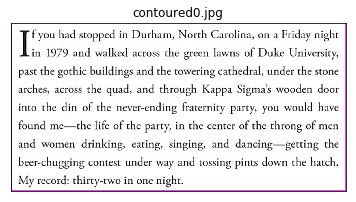

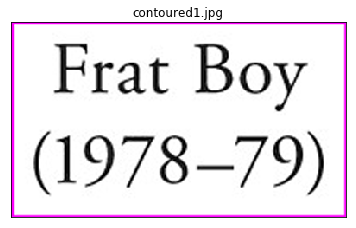

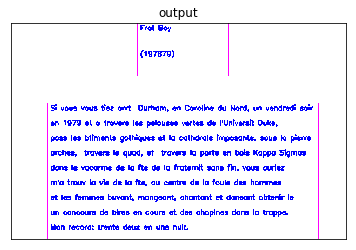

In [65]:
def translate_image(image,lang='fr'):
    
    gray = cv2.cvtColor(image,cv2.COLOR_BGR2GRAY) # grayscale
    _,thresh = cv2.threshold(gray,150,255,cv2.THRESH_BINARY_INV) # threshold
    kernel = cv2.getStructuringElement(cv2.MORPH_CROSS,(3,3))
    dilated = cv2.dilate(thresh,kernel,iterations = 13) # dilate
    _, contours, hierarchy = cv2.findContours(dilated,cv2.RETR_EXTERNAL,cv2.CHAIN_APPROX_NONE) # get contours
    #print contours length 
    print(len(contours))
    translator=Translator()
    i=0 
    # for each contour found, draw a rectangle around it on original image
    for contour in contours:
        # get rectangle bounding contour
        [x,y,w,h] = cv2.boundingRect(contour)

        # discard areas that are too large
        if h>500 and w>500:
            continue

        # discard areas that are too small
        if h<40 or w<40:
            continue

        # draw rectangle around contour on original image
        cv2.rectangle(image,(x,y),(x+w,y+h),(255,0,255),2)

        #print(contour)
        crop = image[y:y+h,x:x+w]
        crop = cv2.resize(crop,(2*w, 2*h), interpolation = cv2.INTER_CUBIC)

        croppedName="contoured"+str(i)+".jpg"
        showImage( crop,croppedName,True)
        cv2.imwrite(croppedName, crop)
        text = pytesseract.image_to_string(crop)
        print(text)
        i=i+1
        text=text.encode('ascii','ignore') 
        text_list=text.splitlines()
        new_list=[tx for tx in text_list if tx!='']
        if len(new_list)==0: continue
        inc = h/(len(new_list))
        ###remove text from image 
        image[y:y+h,x:x+w]=255
        cnt=0
        for tx in new_list:
            #####translator###########
            trans=translator.translate(tx,dest=lang)
            trans=trans.text.encode('ascii', 'ignore')
            if cnt==0: y=y+15
            ##write a new text
            cv2.putText(image,trans,(x+5, y),cv2.FONT_HERSHEY_SIMPLEX, 0.5, (0,0,255), 2)

                
            y=y+inc
            cnt=cnt+1
            # write original image with added contours to disk  
    cv2.imwrite("contoured.jpg", image) 
    return image
image = cv2.imread("text.jpg",1)
img=translate_image(image,lang='fr')
showImage(img,"output")